In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm

import mltools.utils.cuda_tools as cuda_tools
device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import importlib
importlib.reload(utils)

memory_available [73679]
best GPU: 0


<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [28]:
os.chdir('/n/home12/cfpark00/ML/ToyCompDiff')

In [29]:
#suite 2
fol="./data/base/seed=0"

In [30]:
config_path=glob.glob(os.path.join(fol, "*.yaml"))[0]
config=utils.load_config(config_path)
logs_path=glob.glob(os.path.join(fol, "logs.pth"))[0]
logs=torch.load(logs_path)

In [31]:
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [35]:
save_steps=config["save_steps"]

In [36]:
def get_model(i_eval):
    model=utils.get_model(config)
    min_vlb=model.get_min_vlb()
    ckpt=torch.load(logs['ckpt_paths'][i_eval])
    for key in list(ckpt.keys()):
        if key[:4]=="net.":
            del ckpt[key]
    model.load_state_dict(ckpt)
    model=model.to(device)
    model=model.eval()
    return model

In [37]:
centerx=0.5#+0.3
centery=0.5#+0.3
d=0.7
arrx=torch.linspace(centerx-d,centerx+d,21)
arry=torch.linspace(centery-d,centery+d,21)
gridpts=torch.stack(torch.meshgrid(arrx,arry,indexing="ij"),dim=-1).reshape(-1,2)
gridpts=gridpts.to(device)
gridpts_np=gridpts.detach().cpu().numpy()
def get_gen_grid(model,T=100,rep=10,multbatch=10):
    gen_grid=[]
    for _ in range(rep):
        if hasattr(model,"gamma"):
            kwargs={"T":T}
        else:
            kwargs={}
        gen=model.generate(c=gridpts.repeat(multbatch,1),**kwargs).reshape(multbatch,*gridpts.shape)
        gen_grid.append(gen)
    gen_grid=torch.cat(gen_grid,dim=0)
    return gen_grid


In [47]:
i_evals=[0,8,15,59]

In [48]:
gen_grid_means=[]
gen_trs=[]
gen_tes=[]
for i_eval in i_evals:
    model=get_model(i_eval)
    
    gen_grid=get_gen_grid(model,T=100,rep=10,multbatch=10)
    gen_grid_np=gen_grid.detach().cpu().numpy()
    gen_grid_mean=gen_grid_np.mean(0)

    gen_tr=model.generate(c=torch.tensor(y_tr).to(dtype=torch.float32,device=device)).detach().cpu().numpy()
    gen_te=model.generate(c=torch.tensor(y_te).to(dtype=torch.float32,device=device)).detach().cpu().numpy()

    gen_grid_means.append(gen_grid_mean)
    gen_trs.append(gen_tr)
    gen_tes.append(gen_te)

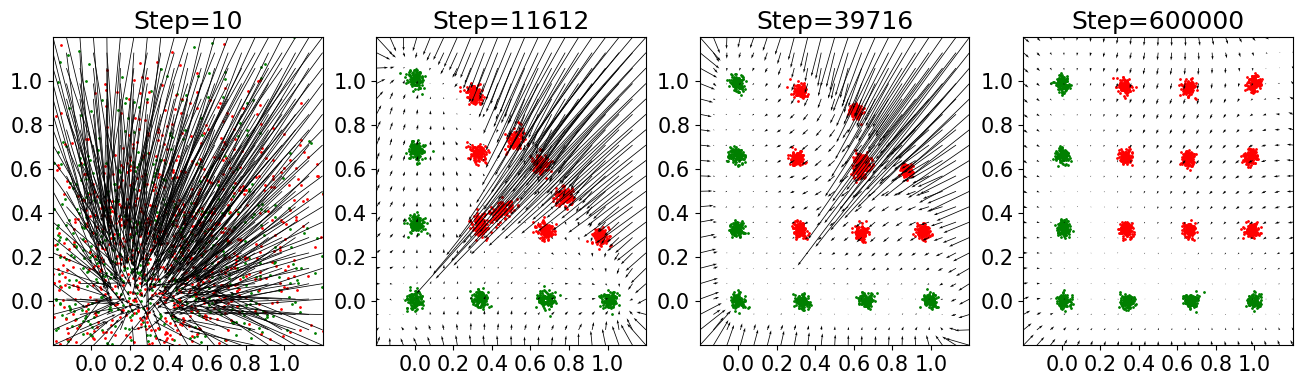

In [52]:
plt.figure(figsize=(16,4))
plt.rcParams.update({'font.size': 15})
for c,i_eval in enumerate(i_evals):
    plt.subplot(1,4,c+1)
    gen_grid_mean=gen_grid_means[c]
    gen_tr=gen_trs[c]
    gen_te=gen_tes[c]

    plt.scatter(gen_tr[:,0],gen_tr[:,1],s=1,c="g")
    plt.scatter(gen_te[:,0],gen_te[:,1],s=1,c="r")
    u=gen_grid_mean[:,0]-gridpts_np[:,0]
    v=gen_grid_mean[:,1]-gridpts_np[:,1]
    plt.quiver(gridpts_np[:,0],gridpts_np[:,1],u,v,angles="xy",scale_units='xy', scale=1)
    plt.xlim(centerx-d,centerx+d)
    plt.ylim(centery-d,centery+d)
    plt.title(f"Step={save_steps[i_eval]}")
    plt.xticks(np.linspace(0.0,1.0,6))
    plt.yticks(np.linspace(0.0,1.0,6))
plt.savefig("./figures/overfit.png")

In [122]:
i_evals=[15,59]

In [124]:
sel=(l_tr==12)
xs=x_tr[sel]+np.array([1.0,0.0])[None,:]
ys=y_tr[sel]
xs_torch1=torch.tensor(xs).to(dtype=torch.float32,device=device)
ys_torch1=torch.tensor(ys).to(dtype=torch.float32,device=device)
sel=(l_tr==12)
xs=x_tr[sel]+np.array([0.5,0.5])[None,:]
ys=y_tr[sel]
xs_torch2=torch.tensor(xs).to(dtype=torch.float32,device=device)
ys_torch2=torch.tensor(ys).to(dtype=torch.float32,device=device)

In [151]:
gen_trs_ft=[]
gen_tes_ft=[]
lossess=[]
for i_ft in range(2):
    xs_torch=xs_torch1 if i_ft==0 else xs_torch2
    ys_torch=ys_torch1 if i_ft==0 else ys_torch2
    for lr,n_steps in zip([3e-4,5e-5],[2000,3000]):
        for i_eval in i_evals:
            model=get_model(i_eval)

            model.train()
            opt=torch.optim.AdamW(model.parameters(),lr=lr)
            losses=[]
            for i in tqdm.tqdm(range(n_steps)):
                loss=model.get_loss(x=xs_torch,c=ys_torch)
                opt.zero_grad()
                loss.backward()
                opt.step()
                losses.append(loss.item())
            gen_tr_ft=model.generate(c=torch.tensor(y_tr).to(dtype=torch.float32,device=device)).detach().cpu().numpy()
            gen_te_ft=model.generate(c=torch.tensor(y_te).to(dtype=torch.float32,device=device)).detach().cpu().numpy()

            gen_trs_ft.append(gen_tr_ft)
            gen_tes_ft.append(gen_te_ft)
            lossess.append(losses)

100%|██████████| 3000/3000 [00:10<00:00, 280.87it/s]


In [152]:
gen_trs_ft=np.stack(gen_trs_ft,axis=0).reshape(2,2,2,-1,2)
gen_tes_ft=np.stack(gen_tes_ft,axis=0).reshape(2,2,2,-1,2)

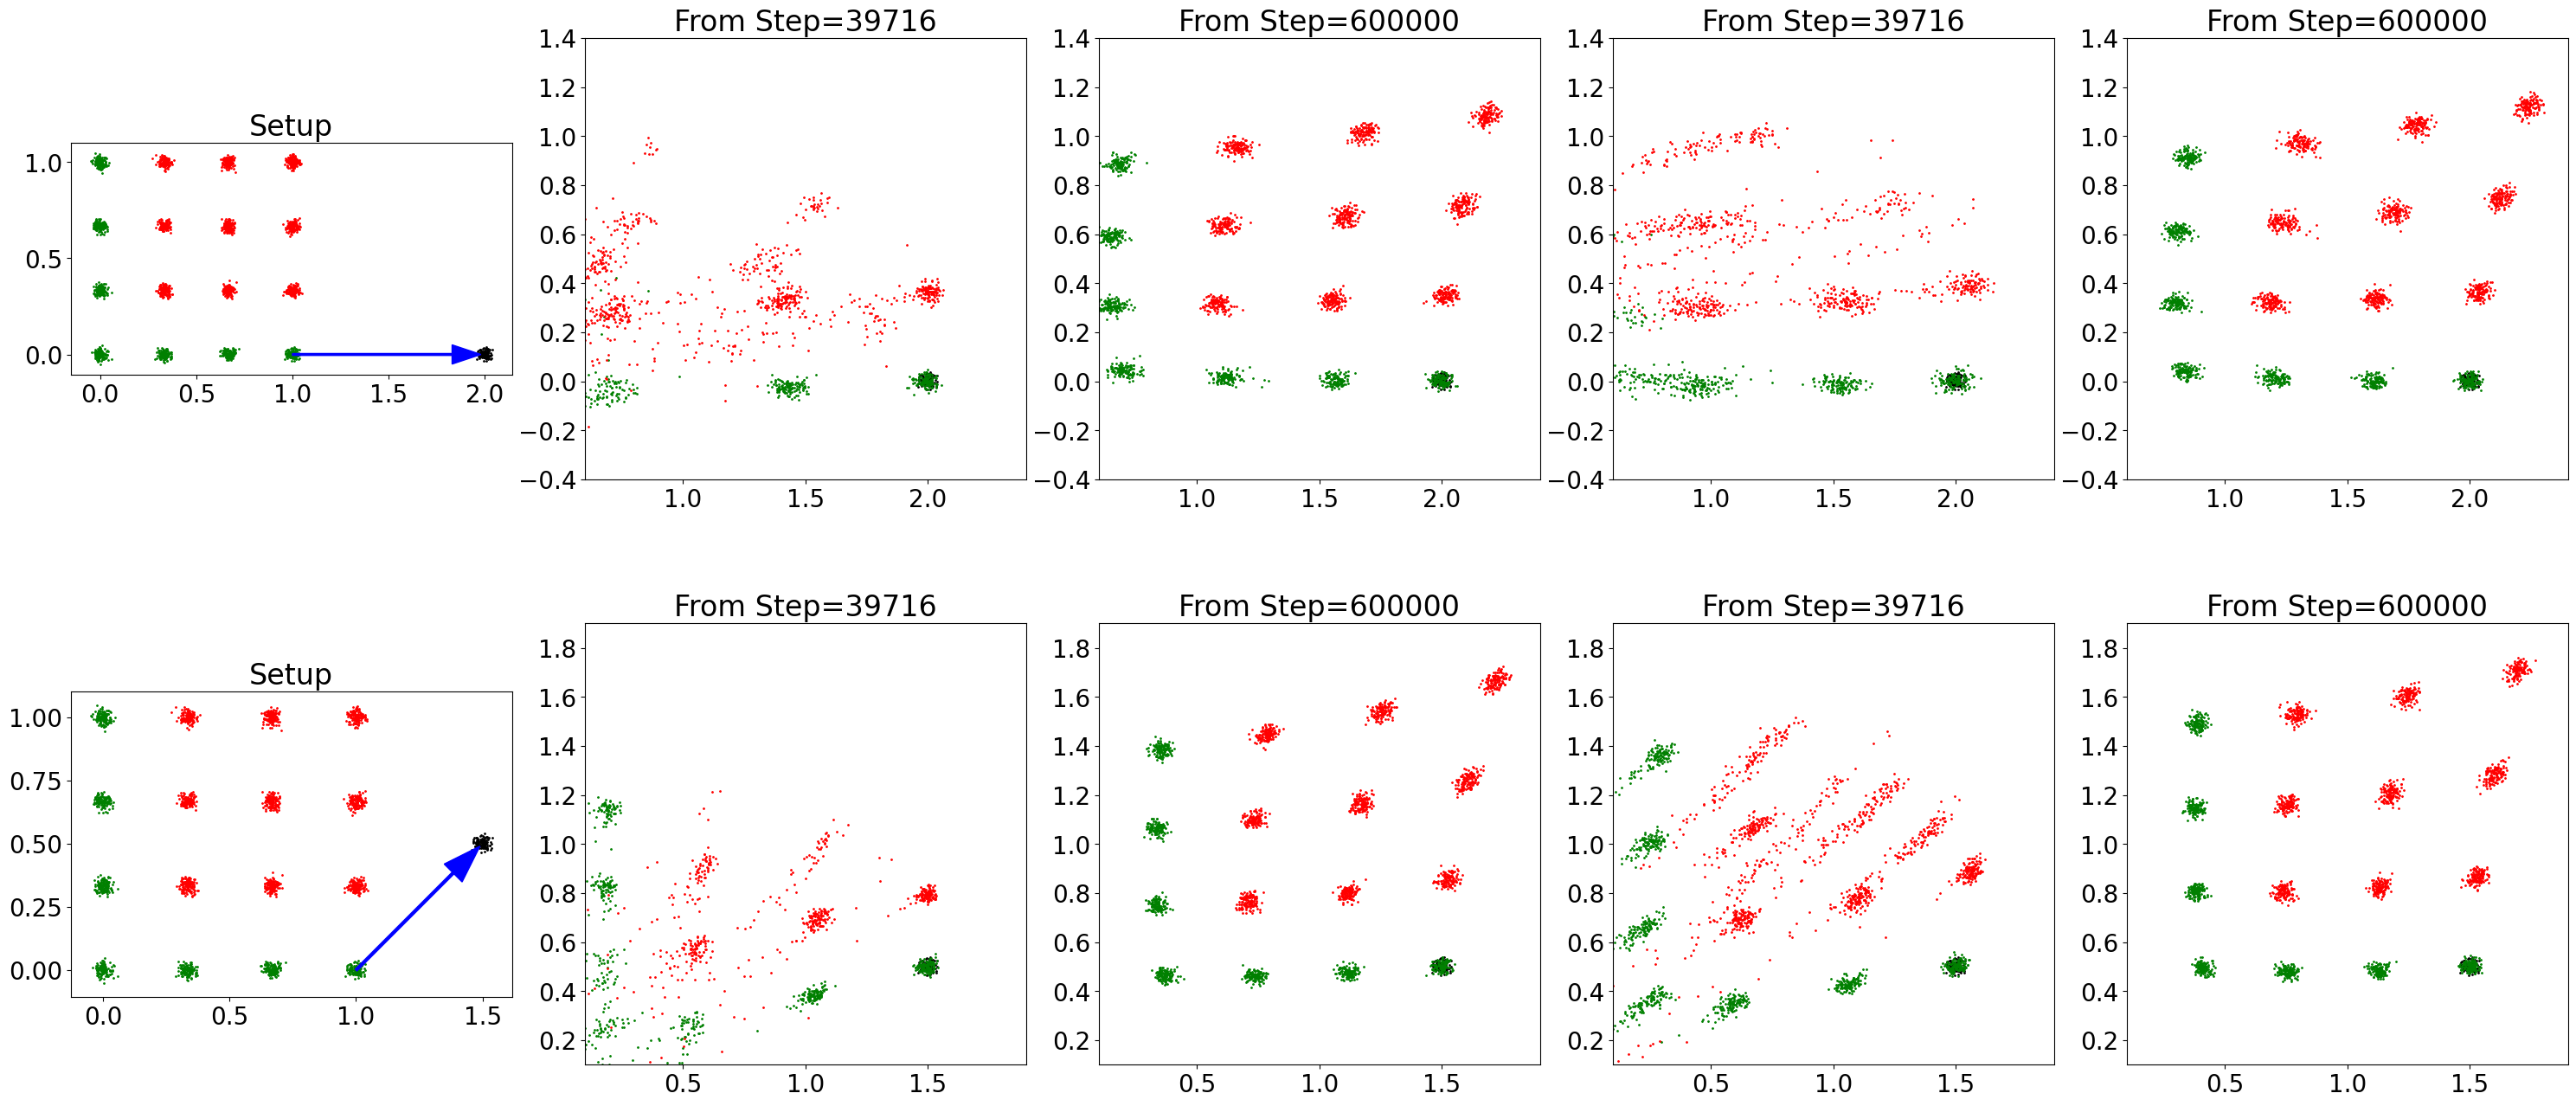

In [157]:
plt.figure(figsize=(30,14))
plt.rcParams.update({'font.size': 20})
for row in range(2):
    for col in range(5):
        plt.subplot(2,5,row*5+col+1)
        if col==0:
            xs=xs_torch1 if row==0 else xs_torch2
            xs=xs.detach().cpu().numpy()
            plt.scatter(x_tr[:,0],x_tr[:,1],s=1,c="g")
            plt.scatter(x_te[:,0],x_te[:,1],s=1,c="r")
            plt.scatter(xs[:,0],xs[:,1],s=1,c="black")
            if row==0:
                plt.arrow(1.,0.,0.98,0.,color="blue",width=0.01,head_width=0.1,length_includes_head=True)
            else:
                plt.arrow(1.,0.,0.49,0.49,color="blue",width=0.01,head_width=0.1,length_includes_head=True)
            plt.gca().set_aspect('equal')
            xlims=plt.gca().get_xlim()
            ylims=plt.gca().get_ylim()
            plt.title("Setup")
        else:
            ii=col-1
            i_lr=ii//2
            i_i_eval=ii%2
            gen_tr_ft=gen_trs_ft[row,i_lr,i_i_eval]
            gen_te_ft=gen_tes_ft[row,i_lr,i_i_eval]
            plt.scatter(xs[:,0],xs[:,1],s=1,c="black")
            plt.scatter(gen_tr_ft[:,0],gen_tr_ft[:,1],s=1,c="g")
            plt.scatter(gen_te_ft[:,0],gen_te_ft[:,1],s=1,c="r")
            if row==0:
                plt.xlim(0.6,2.4)
                plt.ylim(-0.4,1.4)
            else:
                plt.xlim(0.1,1.9)
                plt.ylim(0.1,1.9)
            plt.title(f"From Step={save_steps[i_evals[i_i_eval]]}")
            #plt.xticks(np.linspace(0.0,1.0,6))
            #plt.yticks(np.linspace(0.0,1.0,6))
            plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig("./figures/fine_tuning.png")


In [ ]:

for c,i_eval in enumerate(i_evals):
    gen_tr_ft=gen_trs_ft[c]
    gen_te_ft=gen_tes_ft[c]
    plt.subplot(2,5,c+2)
    plt.scatter(gen_tr_ft[:,0],gen_tr_ft[:,1],s=1,c="g")
    plt.scatter(gen_te_ft[:,0],gen_te_ft[:,1],s=1,c="r")
    #plt.xlim(0.2,1.8)
    plt.xlim(0.7,2.3)
    #plt.ylim(0.2,1.8)
    plt.ylim(-0.3,1.3)
    plt.title(f"Step={save_steps[i_eval]}")
    #plt.xticks(np.linspace(0.0,1.0,6))
    #plt.yticks(np.linspace(0.0,1.0,6))
    plt.gca().set_aspect("equal")

In [121]:
sel0=(l_tr==0)
sel1=(l_tr==12)
sel2=(l_tr==3)

xs0=x_tr[sel0]+np.array([1.0,1.0])[None,:]
ys0=y_tr[sel0]
xs1=x_tr[sel1]+np.array([0.5,0.0])[None,:]
ys1=y_tr[sel1]
xs2=x_tr[sel2]+np.array([0.5,0.5])[None,:]
ys2=y_tr[sel2]
#xs=xs1#np.concatenate([xs1,xs2],axis=0)
#ys=ys1#np.concatenate([ys1,ys2],a?xis=0)
#xs=np.concatenate([xs0,xs1,xs2],axis=0)
#ys=np.concatenate([ys0,ys1,ys2],axis=0)
xs=np.concatenate([xs1],axis=0)
ys=np.concatenate([ys1],axis=0)
xs_torch=torch.tensor(xs).to(dtype=torch.float32,device=device)
ys_torch=torch.tensor(ys).to(dtype=torch.float32,device=device)
xs_torch.shape,ys_torch.shape

(torch.Size([128, 2]), torch.Size([128, 2]))

In [117]:
gen_trs_ft=[]
gen_tes_ft=[]
lossess=[]
for i_eval in i_evals:
    model=get_model(i_eval)

    model.train()
    opt=torch.optim.AdamW(model.parameters(),lr=3e-4)
    n_steps=4000
    losses=[]
    for i in tqdm.tqdm(range(n_steps)):
        loss=model.get_loss(x=xs_torch,c=ys_torch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    gen_tr_ft=model.generate(c=torch.tensor(y_tr).to(dtype=torch.float32,device=device)).detach().cpu().numpy()
    gen_te_ft=model.generate(c=torch.tensor(y_te).to(dtype=torch.float32,device=device)).detach().cpu().numpy()

    gen_trs_ft.append(gen_tr_ft)
    gen_tes_ft.append(gen_te_ft)
    lossess.append(losses)

100%|██████████| 4000/4000 [00:14<00:00, 281.28it/s]


In [118]:
#plt.plot(lossess[4]-model.get_min_vlb())
#plt.yscale("log")

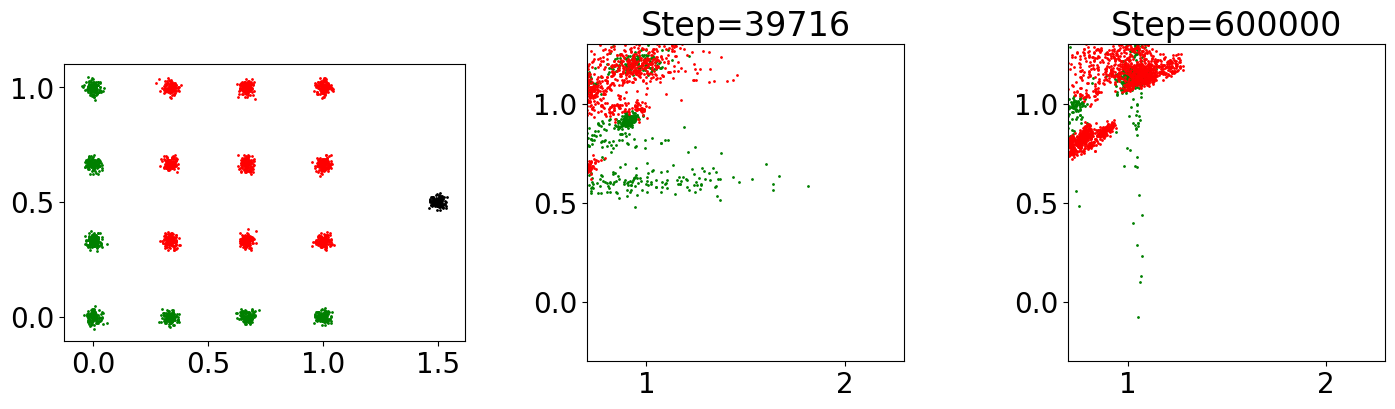

In [145]:
plt.figure(figsize=(30,14))
plt.rcParams.update({'font.size': 20})
plt.subplot(3,5,1)
plt.scatter(x_tr[:,0],x_tr[:,1],s=1,c="g")
plt.scatter(x_te[:,0],x_te[:,1],s=1,c="r")
plt.scatter(xs[:,0],xs[:,1],s=1,c="black")
#plt.arrow(1.,0.,0.49,0.49,color="pink",width=0.01,head_width=0.1,length_includes_head=True)
plt.gca().set_aspect('equal')
xlims=plt.gca().get_xlim()
ylims=plt.gca().get_ylim()

for c,i_eval in enumerate(i_evals):
    gen_tr_ft=gen_trs_ft[c]
    gen_te_ft=gen_tes_ft[c]
    plt.subplot(3,5,c+2)
    plt.scatter(gen_tr_ft[:,0],gen_tr_ft[:,1],s=1,c="g")
    plt.scatter(gen_te_ft[:,0],gen_te_ft[:,1],s=1,c="r")
    #plt.xlim(0.2,1.8)
    plt.xlim(0.7,2.3)
    #plt.ylim(0.2,1.8)
    plt.ylim(-0.3,1.3)
    plt.title(f"Step={save_steps[i_eval]}")
    #plt.xticks(np.linspace(0.0,1.0,6))
    #plt.yticks(np.linspace(0.0,1.0,6))
    plt.gca().set_aspect("equal")

In [144]:
i_evals

[15, 59]

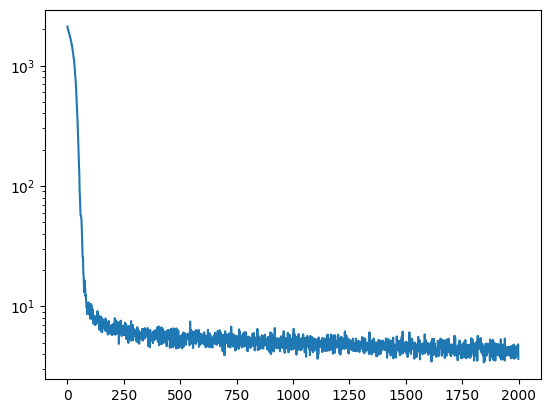

In [520]:
plt.plot(losses-model.get_min_vlb())
plt.yscale("log")

In [521]:
gen_grid_ft=get_gen_grid(model,T=100,rep=10,multbatch=10)
gen_grid_ft_np=gen_grid_ft.detach().cpu().numpy()
gen_grid_ft_mean=gen_grid_ft_np.mean(0)

gen_tr_ft=model.generate(c=torch.tensor(y_tr).to(dtype=torch.float32,device=device)).detach().cpu().numpy()
gen_te_ft=model.generate(c=torch.tensor(y_te).to(dtype=torch.float32,device=device)).detach().cpu().numpy()

(0.4, 1.6)

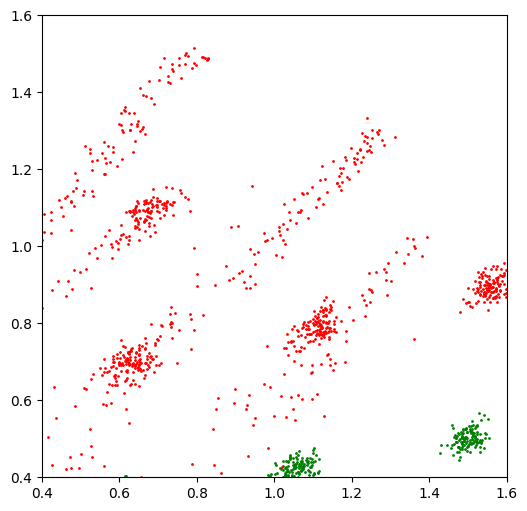

In [524]:
plt.figure(figsize=(6,6))
plt.scatter(gen_tr_ft[:,0],gen_tr_ft[:,1],s=1,c="g")
plt.scatter(gen_te_ft[:,0],gen_te_ft[:,1],s=1,c="r")
#plt.xlim(centerx-d,centerx+d+0.25)
#plt.ylim(centery-d,centery+d)
#plt.xlim(xlims[0],xlims[1])
#plt.xlim(*xlims)
#plt.ylim(*ylims)
plt.xlim(0.4,1.6)
plt.ylim(0.4,1.6)

In [1344]:
xs=x_tr[l_tr==12]+np.array([0.5,0])[None,:]
ys=y_tr[l_tr==12]
xs_torch=torch.tensor(xs).to(dtype=torch.float32,device=device)
ys_torch=torch.tensor(ys).to(dtype=torch.float32,device=device)

x_tr_ft_gens=[]
x_te_ft_gens=[]
for i_eval in tqdm.tqdm(range(len(logs["ckpts"]))):
    model.load_state_dict(logs['ckpts'][i_eval])
    model.train()
    opt=torch.optim.Adam(model.parameters(),lr=1e-3)
    n_steps=2000
    for i in range(n_steps):
        loss=model.get_loss(x=xs_torch,c=ys_torch)
        opt.zero_grad()
        loss.backward()
        opt.step()
    model.eval()
    gen_tr=model.generate(c=torch.tensor(y_tr).to(dtype=torch.float32,device=device)).detach().cpu().numpy()
    gen_te=model.generate(c=torch.tensor(y_te).to(dtype=torch.float32,device=device)).detach().cpu().numpy()
    x_tr_ft_gens.append(gen_tr)
    x_te_ft_gens.append(gen_te)
x_tr_ft_gens=np.stack(x_tr_ft_gens,axis=0)
x_te_ft_gens=np.stack(x_te_ft_gens,axis=0)
x_tr_ft_gens.shape,x_te_ft_gens.shape

  0%|          | 0/50 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [1119]:
x_tr_ft_gens=np.clip(x_tr_ft_gens,-1.,2.5)
x_te_ft_gens=np.clip(x_te_ft_gens,-1.,2.5)

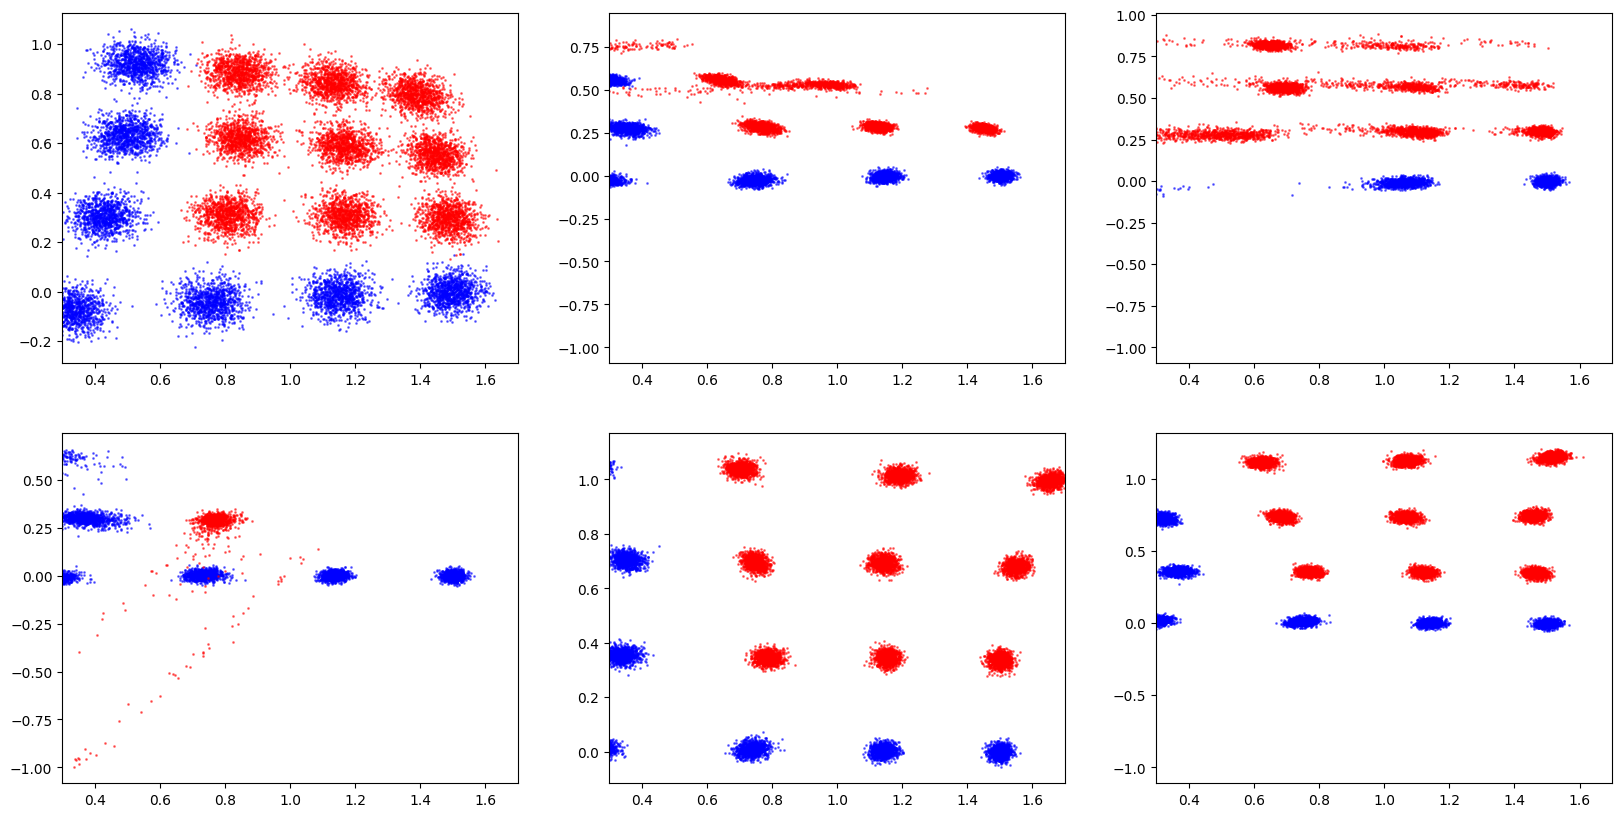

In [1176]:
plt.figure(figsize=(20,10))
for i_fig,i_eval in enumerate([0,10,20,30,40,49]):
    plt.subplot(2,3,i_fig+1)
    plt.scatter(x_tr_ft_gens[i_eval,:,0],x_tr_ft_gens[i_eval,:,1],s=1,c="b",alpha=0.5)
    plt.scatter(x_te_ft_gens[i_eval,:,0],x_te_ft_gens[i_eval,:,1],s=1,c="r",alpha=0.5)
    plt.xlim(0.3,1.7)

In [1121]:
x_tr_ft_expected_means=means[l_tr]+np.array([0.5,0])[None,:]
dev_tr_ft=x_tr_ft_gens-x_tr_ft_expected_means[None]
mse_meandev_tr_ft=((dev_tr_ft.mean(1))**2).mean(-1)
x_te_ft_expected_mean=means[l_te]+np.array([0.5,0])[None,:]
dev_te_ft=x_te_ft_gens-x_te_ft_expected_mean[None]
mse_meandev_te_ft=((dev_te_ft.mean(1))**2).mean(-1)

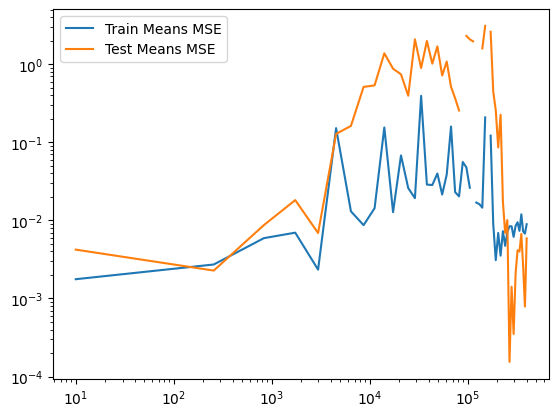

In [1122]:
plt.plot(save_steps,mse_meandev_tr_ft,label="Train Means MSE")
plt.plot(save_steps,mse_meandev_te_ft,label="Test Means MSE")
plt.yscale("log")
plt.xscale("log")
plt.legend()

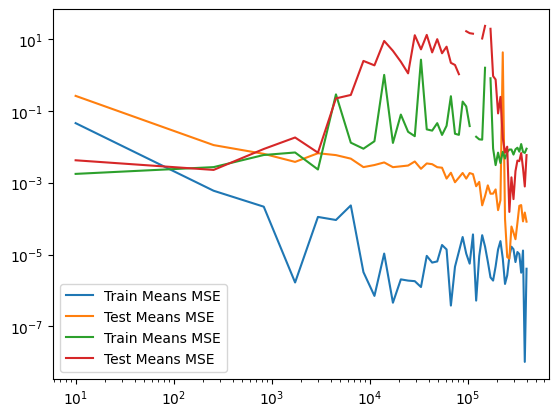

In [1118]:
plt.plot(save_steps,means_mse_tr,label="Train Means MSE")
plt.plot(save_steps,means_mse_te,label="Test Means MSE")

#plt.plot(save_steps,accs_tr,label="Train Acc")
#plt.plot(save_steps,accs_te,label="Test Acc")

plt.plot(save_steps,mse_meandev_tr_ft,label="Train Means MSE")
plt.plot(save_steps,mse_meandev_te_ft,label="Test Means MSE")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [93]:
tr_mses=[]
te_mses=[]
Ts=[1,2,5,10,20,50,100,200]
for T in Ts:
    c_tr=torch.tensor([[0.,0.],[1.,0.],[0.,1.]]).repeat(1000,1).to(device)
    c_te=torch.tensor([[1.,1.]]).repeat(1000,1).to(device)
    gen_new_tr=model.generate(c=c_tr,T=T)
    gen_new_te=model.generate(c=c_te,T=T)
    tr_mses.append( ((gen_new_tr-c_tr)**2).sum(1).mean(0).item())
    te_mses.append( ((gen_new_te-c_te)**2).sum(1).mean(0).item())

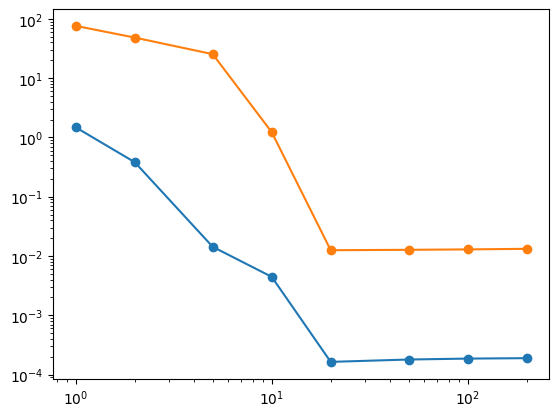

In [94]:
plt.plot(Ts,tr_mses,marker="o")
plt.plot(Ts,te_mses,marker="o")
plt.yscale("log")
plt.xscale("log")

In [33]:
gen_new_te_np.shape

(1000, 2)

In [34]:
gens_tr,gens_te=logs["gens"][i_eval]

In [35]:
#c=[0.,0.]
batch=16

In [36]:
x_tr=torch.tensor(np.random.multivariate_normal([0.,0.],[[0.0001,0.],[0.,0.0001]],3000)).to(device).to(torch.float32)
x_tr[1000:2000]+=torch.tensor([1.,0.]).to(device)
x_tr[2000:3000]+=torch.tensor([0.,1.]).to(device)
c_tr=x_tr
x_tr.shape,c_tr.shape

(torch.Size([3000, 2]), torch.Size([3000, 2]))

In [37]:
opt=torch.optim.Adam(model.parameters(),lr=1e-4)
model.train()
for i in range(50):
    c01=torch.tensor([0.,1.])[None].repeat(batch,1).to(device)
    c10=torch.tensor([0.,1])[None].repeat(batch,1).to(device)
    c11=torch.tensor([1.,1.])[None].repeat(batch,1).to(device)
    x=torch.randn(batch,2).to(device)+0.5
    ts = torch.randint(0, 1, (batch,)).long().to(x.device)
    #if np.random.random()<0.5:
    l=torch.norm(model(x=x,c=c11,t=ts)-model(x=x,c=c01,t=ts)-model(x=x,c=c10,t=ts))
    #else:
    #    l=torch.norm(model(x=x,c=c11,t=ts)-model(x=x,c=c10,t=ts))

    l=l+model.get_loss(x=x_tr,c=c_tr)
    
    #loss=model.get_loss(x=x,c=c11)
    #l=loss.var()
    
    #c1=torch.randn(batch,2).to(device)+0.5
    #c2=torch.randn(batch,2).to(device)+0.5
    #x1=torch.randn(batch,2).to(device)+0.5
    #x2=torch.randn(batch,2).to(device)+0.5
    #ts = torch.randint(0, model.T, (batch,)).long().to(c.device)
    #l=torch.norm(model(x=x1,c=c1,t=ts)-model(x=x1,c=c2,t=ts))

    #GENERAL IDEA: calculate a loss based on conditioning
    
    #l=model.get_loss(x=x,c=c)

    opt.zero_grad()
    l.backward()
    opt.step()
    print(l.item())


AttributeError: 'GenVDiff' object has no attribute 'T'

In [95]:
model=utils.get_model(config)

In [96]:
gammas=[]
for i,step in enumerate(logs["save_steps"]):
    model.load_state_dict(logs["ckpts"][i])
    gammas.append(model.model.gamma(torch.linspace(0,1,100)))
gammas=torch.stack(gammas,dim=0)
gammas=gammas.detach().cpu().numpy()
gammas.shape

(20, 100)

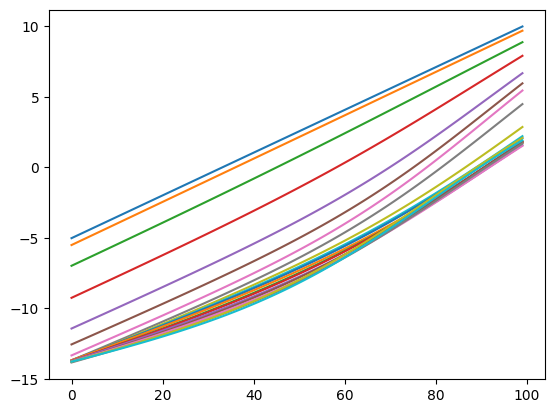

In [98]:
for gamma in gammas:
    plt.plot(gamma)

In [201]:
gradnorm.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [204]:
x = torch.randn(3, requires_grad=True)
x.grad

In [ ]:
ts = torch.randint(0, self.T, (batch_size,)).long().to(x.device)

In [130]:
c=torch.tensor(c)[None].repeat(batch,1).to(device)
x=torch.randn(batch,2).to(device)
model.train()
l=model.get_loss(x=x,c=c)

In [131]:
l

tensor(5.5250, device='cuda:0', grad_fn=<MseLossBackward0>)

In [126]:
res.sum().backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
c=gridpts_np[:,0]
model=model.eval()

In [101]:
sup_fol="./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=0.5_h=256/"
sup_fol="./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=0.3_h=256/"
#sup_fol="./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=0.5_h=256/"
#sup_fol="./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=1.0_h=256/"
#sup_fol="./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=0.5_h=1024/"
#sup_fol="./data/Det_dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=0.5_h=256/"

In [ ]:
def get_dim(fol):
    return int(os.path.split(os.path.split(fol)[1])[1].split("_")[0].replace("dim=",""))

In [123]:
init_scales=[0.01,0.1,0.3,0.5,1.0]

mse_trss=[]
mse_tess=[]
for init_scale in init_scales:
    print("init_scale",init_scale)
    sup_fol=f"./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis={init_scale}_h=256/"
    fols=glob.glob(os.path.join(sup_fol, "*"))
    fols=sorted(fols, key=get_dim)
    dims=[get_dim(fol) for fol in fols]

    mse_trs=[]
    mse_tes=[]
    for fol in fols:
        logs_file=os.path.join(fol,"logs.pth")
        logs=torch.load(logs_file)
        yaml_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
        config=utils.load_config(yaml_file)
        x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config)
        model=utils.get_model(config)
        model.load_state_dict(logs["ckpts"][-1])
        model.to(device)
        model.eval()
        with torch.no_grad():
            x_tr_gen=model.generate(c=torch.tensor(y_tr).float().to(device))
            mse_tr=torch.nn.functional.mse_loss(x_tr_gen,torch.tensor(x_tr).float().to(device))
            x_te_gen=model.generate(c=torch.tensor(y_te).float().to(device))
            mse_te=torch.nn.functional.mse_loss(x_te_gen,torch.tensor(x_te).float().to(device))
            mse_trs.append(mse_tr.item())
            mse_tes.append(mse_te.item())
    mse_trss.append(mse_trs)
    mse_tess.append(mse_tes)
mse_trss=np.array(mse_trss)
mse_tess=np.array(mse_tess)

init_scale 0.01
init_scale 0.1
init_scale 0.3
init_scale 0.5
init_scale 1.0


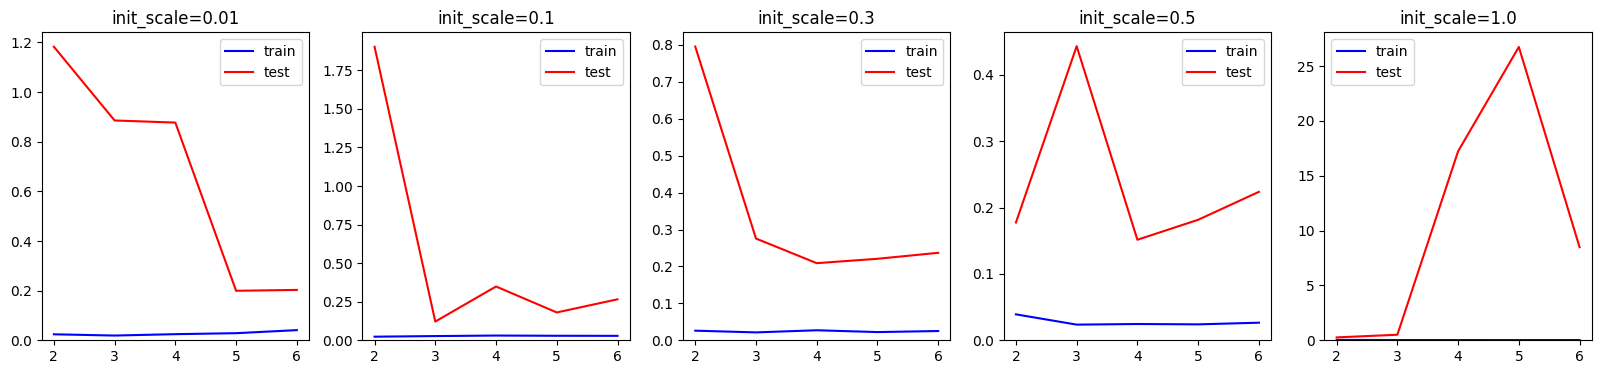

In [124]:
plt.figure(figsize=(20,4))
c=0
for init_scale,mse_trs,mse_tes in zip(init_scales,mse_trss,mse_tess):
    plt.subplot(1,len(init_scales),c+1)
    plt.plot(dims,mse_trs,label=f"train",color="blue")
    plt.plot(dims,mse_tes,label=f"test",color="red")
    plt.title(f"init_scale={init_scale}")
    plt.legend()
    plt.ylim(bottom=0)
    c+=1

In [125]:
init_scales=[0.01,0.1,0.3,0.5,1.0]

mse_trss=[]
mse_tess=[]
for init_scale in init_scales:
    print("init_scale",init_scale)
    sup_fol=f"./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis={init_scale}_h=256/"
    fols=glob.glob(os.path.join(sup_fol, "*"))
    fols=sorted(fols, key=get_dim)
    dims=[get_dim(fol) for fol in fols]

    mse_trs=[]
    mse_tes=[]
    for fol in fols:
        logs_file=os.path.join(fol,"logs.pth")
        logs=torch.load(logs_file)
        i_best=np.argmin(logs["te_losses"])
        yaml_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
        config=utils.load_config(yaml_file)
        x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config)
        model=utils.get_model(config)
        model.load_state_dict(logs["ckpts"][i_best])
        model.to(device)
        model.eval()
        with torch.no_grad():
            x_tr_gen=model.generate(c=torch.tensor(y_tr).float().to(device))
            mse_tr=torch.nn.functional.mse_loss(x_tr_gen,torch.tensor(x_tr).float().to(device))
            x_te_gen=model.generate(c=torch.tensor(y_te).float().to(device))
            mse_te=torch.nn.functional.mse_loss(x_te_gen,torch.tensor(x_te).float().to(device))
            mse_trs.append(mse_tr.item())
            mse_tes.append(mse_te.item())
    mse_trss.append(mse_trs)
    mse_tess.append(mse_tes)
mse_trss=np.array(mse_trss)
mse_tess=np.array(mse_tess)

init_scale 0.01
init_scale 0.1
init_scale 0.3
init_scale 0.5
init_scale 1.0


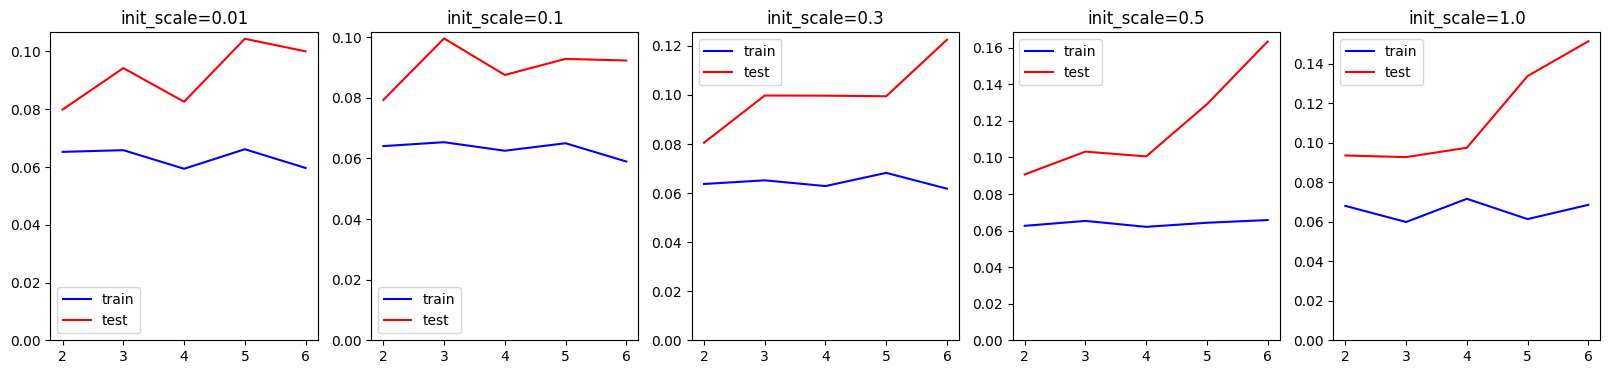

In [126]:
plt.figure(figsize=(20,4))
c=0
for init_scale,mse_trs,mse_tes in zip(init_scales,mse_trss,mse_tess):
    plt.subplot(1,len(init_scales),c+1)
    plt.plot(dims,mse_trs,label=f"train",color="blue")
    plt.plot(dims,mse_tes,label=f"test",color="red")
    plt.title(f"init_scale={init_scale}")
    plt.legend()
    plt.ylim(bottom=0)
    c+=1

In [127]:
ss=[0.01,0.03,0.1]

mse_trss=[]
mse_tess=[]
for s in ss:
    print("s",s)
    sup_fol=f"./data/dim=var_m=1.0_s={s}_infs=1.0_T=100_inis=0.5_h=256/"
    fols=glob.glob(os.path.join(sup_fol, "*"))
    fols=sorted(fols, key=get_dim)
    dims=[get_dim(fol) for fol in fols]

    mse_trs=[]
    mse_tes=[]
    for fol in fols:
        logs_file=os.path.join(fol,"logs.pth")
        logs=torch.load(logs_file)
        i_best=np.argmin(logs["te_losses"])
        yaml_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
        config=utils.load_config(yaml_file)
        x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config)
        model=utils.get_model(config)
        model.load_state_dict(logs["ckpts"][i_best])
        model.to(device)
        model.eval()
        with torch.no_grad():
            x_tr_gen=model.generate(c=torch.tensor(y_tr).float().to(device))
            mse_tr=torch.nn.functional.mse_loss(x_tr_gen,torch.tensor(x_tr).float().to(device))
            x_te_gen=model.generate(c=torch.tensor(y_te).float().to(device))
            mse_te=torch.nn.functional.mse_loss(x_te_gen,torch.tensor(x_te).float().to(device))
            mse_trs.append(mse_tr.item())
            mse_tes.append(mse_te.item())
    mse_trss.append(mse_trs)
    mse_tess.append(mse_tes)
mse_trss=np.array(mse_trss)
mse_tess=np.array(mse_tess)

s 0.01
s 0.03
s 0.1


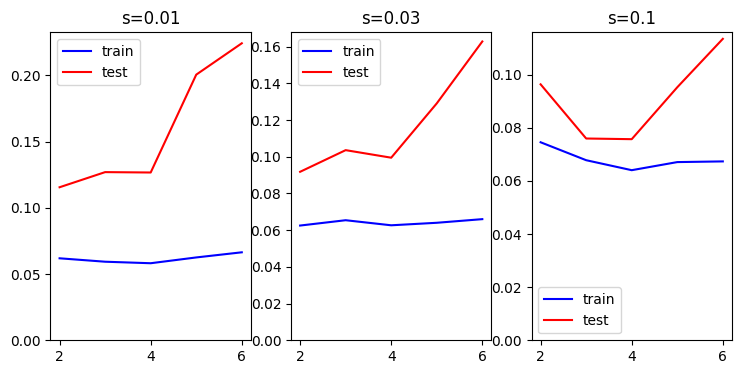

In [128]:
plt.figure(figsize=(15,4))
c=0
for s,mse_trs,mse_tes in zip(ss,mse_trss,mse_tess):
    plt.subplot(1,len(init_scales),c+1)
    plt.plot(dims,mse_trs,label=f"train",color="blue")
    plt.plot(dims,mse_tes,label=f"test",color="red")
    plt.title(f"s={s}")
    plt.legend()
    plt.ylim(bottom=0)
    c+=1

In [132]:
Ts=[5,10,50,100,200]

mse_trss=[]
mse_tess=[]
for T in Ts:
    print("T",T)
    sup_fol=f"./data/dim=var_m=1.0_s=0.03_infs=1.0_T={T}_inis=0.5_h=256/"
    fols=glob.glob(os.path.join(sup_fol, "*"))
    fols=sorted(fols, key=get_dim)
    dims=[get_dim(fol) for fol in fols]

    mse_trs=[]
    mse_tes=[]
    for fol in fols:
        logs_file=os.path.join(fol,"logs.pth")
        logs=torch.load(logs_file)
        #i_best=np.argmin(logs["te_losses"])
        yaml_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
        config=utils.load_config(yaml_file)
        x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config)
        model=utils.get_model(config)
        model.load_state_dict(logs["ckpts"][-1])
        model.to(device)
        model.eval()
        with torch.no_grad():
            x_tr_gen=model.generate(c=torch.tensor(y_tr).float().to(device))
            mse_tr=torch.nn.functional.mse_loss(x_tr_gen,torch.tensor(x_tr).float().to(device))
            x_te_gen=model.generate(c=torch.tensor(y_te).float().to(device))
            mse_te=torch.nn.functional.mse_loss(x_te_gen,torch.tensor(x_te).float().to(device))
            mse_trs.append(mse_tr.item())
            mse_tes.append(mse_te.item())
    mse_trss.append(mse_trs)
    mse_tess.append(mse_tes)
mse_trss=np.array(mse_trss)
mse_tess=np.array(mse_tess)

T 5
T 10
T 50
T 100
T 200


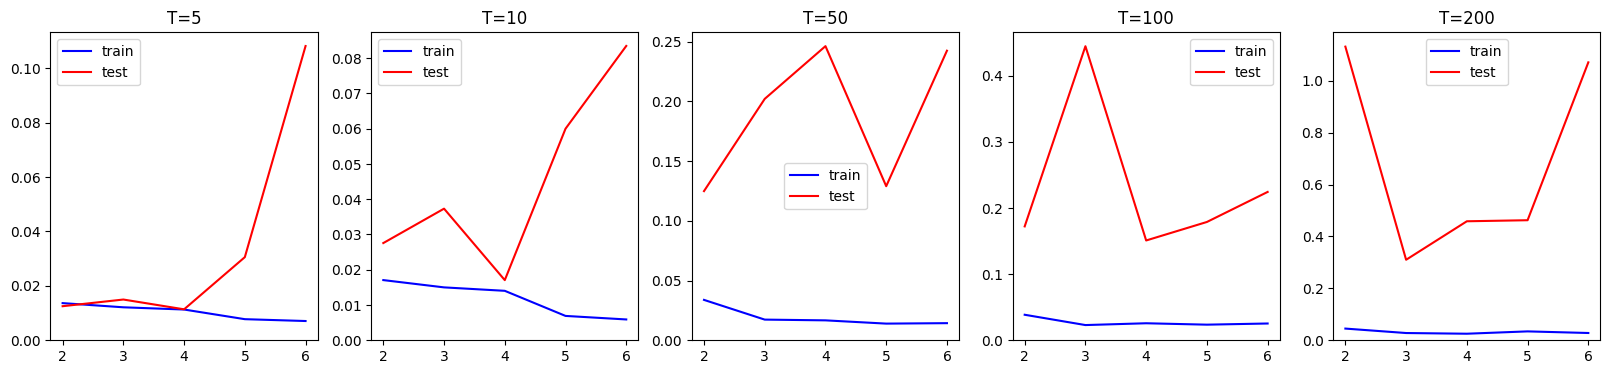

In [133]:
plt.figure(figsize=(20,4))
c=0
for T,mse_trs,mse_tes in zip(Ts,mse_trss,mse_tess):
    plt.subplot(1,len(init_scales),c+1)
    plt.plot(dims,mse_trs,label=f"train",color="blue")
    plt.plot(dims,mse_tes,label=f"test",color="red")
    plt.title(f"T={T}")
    plt.legend()
    plt.ylim(bottom=0)
    c+=1

In [135]:
hs=["64","256","3x256","1024"]

mse_trss=[]
mse_tess=[]
for h in hs:
    print("h",h)
    sup_fol=f"./data/dim=var_m=1.0_s=0.03_infs=1.0_T=100_inis=0.5_h={h}/"
    fols=glob.glob(os.path.join(sup_fol, "*"))
    fols=sorted(fols, key=get_dim)
    dims=[get_dim(fol) for fol in fols]

    mse_trs=[]
    mse_tes=[]
    for fol in fols:
        logs_file=os.path.join(fol,"logs.pth")
        logs=torch.load(logs_file)
        #i_best=np.argmin(logs["te_losses"])
        yaml_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
        config=utils.load_config(yaml_file)
        x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config)
        model=utils.get_model(config)
        model.load_state_dict(logs["ckpts"][-1])
        model.to(device)
        model.eval()
        with torch.no_grad():
            x_tr_gen=model.generate(c=torch.tensor(y_tr).float().to(device))
            mse_tr=torch.nn.functional.mse_loss(x_tr_gen,torch.tensor(x_tr).float().to(device))
            x_te_gen=model.generate(c=torch.tensor(y_te).float().to(device))
            mse_te=torch.nn.functional.mse_loss(x_te_gen,torch.tensor(x_te).float().to(device))
            mse_trs.append(mse_tr.item())
            mse_tes.append(mse_te.item())
    mse_trss.append(mse_trs)
    mse_tess.append(mse_tes)
mse_trss=np.array(mse_trss)
mse_tess=np.array(mse_tess)

h 64
h 256
h 3x256
h 1024


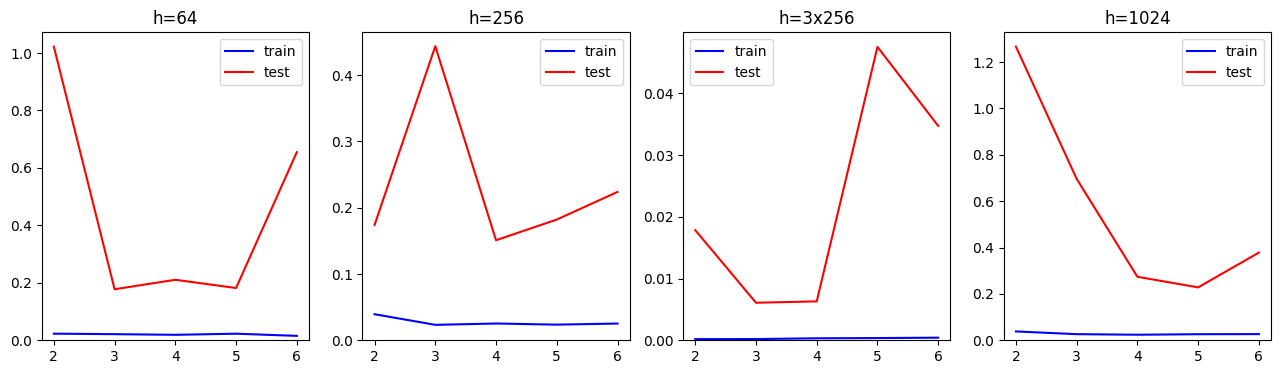

In [137]:
plt.figure(figsize=(20,4))
c=0
for h,mse_trs,mse_tes in zip(hs,mse_trss,mse_tess):
    plt.subplot(1,len(init_scales),c+1)
    plt.plot(dims,mse_trs,label=f"train",color="blue")
    plt.plot(dims,mse_tes,label=f"test",color="red")
    plt.title(f"h={h}")
    plt.legend()
    plt.ylim(bottom=0)
    c+=1

In [114]:
logs.keys()

dict_keys(['losses', 'save_steps', 'val_losses', 'te_losses', 'ckpts', 'gens', 'gen_losses'])

In [117]:
len(logs['te_losses'])

20

In [116]:
len(logs['ckpts'])

20

In [103]:
mse_trs=[]
mse_tes=[]
for fol in fols:
    logs_file=os.path.join(fol,"logs.pth")
    logs=torch.load(logs_file)
    yaml_file=glob.glob(os.path.join(fol,"*.yaml"))[0]
    config=utils.load_config(yaml_file)
    x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config)
    model=utils.get_model(config)
    model.load_state_dict(logs["ckpts"][-1])
    model.to(device)
    model.eval()
    with torch.no_grad():
        x_tr_gen=model.generate(c=torch.tensor(y_tr).float().to(device))
        mse_tr=torch.nn.functional.mse_loss(x_tr_gen,torch.tensor(x_tr).float().to(device))
        x_te_gen=model.generate(c=torch.tensor(y_te).float().to(device))
        mse_te=torch.nn.functional.mse_loss(x_te_gen,torch.tensor(x_te).float().to(device))
        mse_trs.append(mse_tr.item())
        mse_tes.append(mse_te.item())

dim=2 mse_tr=0.025685643777251244 mse_te=0.8031236529350281
dim=3 mse_tr=0.02116653323173523 mse_te=0.27387377619743347
dim=4 mse_tr=0.027924615889787674 mse_te=0.20990650355815887
dim=5 mse_tr=0.023892395198345184 mse_te=0.21980756521224976
dim=6 mse_tr=0.02591894194483757 mse_te=0.23531104624271393


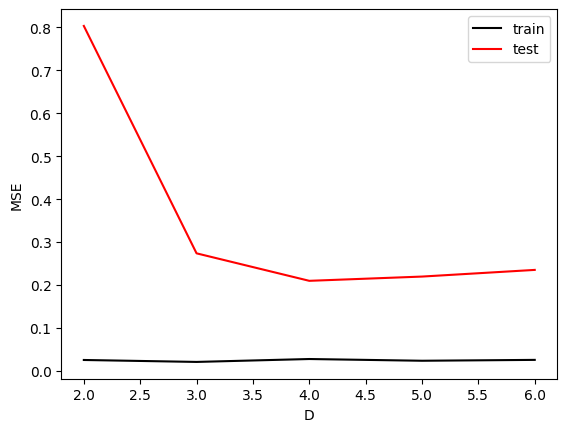

In [104]:
plt.plot(dims,mse_trs,label="train",c="black")
plt.plot(dims,mse_tes,label="test",c="r")
plt.xlabel("D")
plt.ylabel("MSE")
plt.legend()
#plt.ylim(0,1)

In [ ]:
plt.plot(dims,mse_trs,label="train",c="black")
plt.plot(dims,mse_tes,label="test",c="r")
plt.xlabel("D")
plt.ylabel("MSE")
plt.legend()

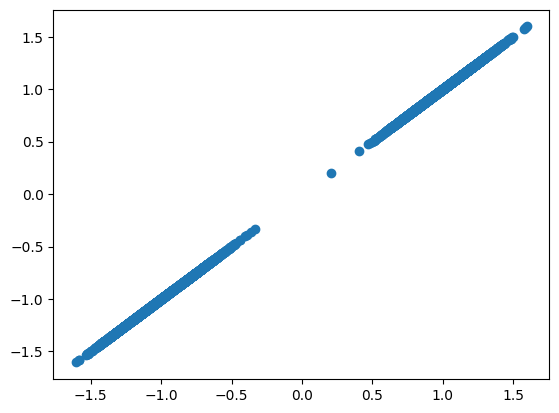

In [68]:
_=plt.scatter(y_tr[:,1],x_tr[:,1])

In [17]:
gen_tr=np.array([gen[0] for gen in torch.load(log_files[0])["gens"]])
gen_te=np.array([gen[1] for gen in torch.load(log_files[0])["gens"]])